**1: Imports and Data Loading**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
print("Training Data Overview:")
print(train.head())

print("\nTest Data Overview:")
print(test.head())

Training Data Overview:
   No      DEWP      TEMP      PRES       Iws        Is        Ir  \
0   1 -1.580878 -1.922250  0.443328 -0.441894 -0.069353 -0.137667   
1   2 -1.580878 -2.004228  0.345943 -0.379306 -0.069353 -0.137667   
2   3 -1.580878 -1.922250  0.248559 -0.343514 -0.069353 -0.137667   
3   4 -1.580878 -2.168183  0.248559 -0.280926 -0.069353 -0.137667   
4   5 -1.511594 -2.004228  0.151174 -0.218339 -0.069353 -0.137667   

              datetime   cbwd_NW   cbwd_SE   cbwd_cv  pm2.5  
0  2010-01-01 00:00:00  1.448138 -0.732019 -0.522096    NaN  
1  2010-01-01 01:00:00  1.448138 -0.732019 -0.522096    NaN  
2  2010-01-01 02:00:00  1.448138 -0.732019 -0.522096    NaN  
3  2010-01-01 03:00:00  1.448138 -0.732019 -0.522096    NaN  
4  2010-01-01 04:00:00  1.448138 -0.732019 -0.522096    NaN  

Test Data Overview:
      No      DEWP      TEMP      PRES       Iws        Is        Ir  \
0  30677  1.190496  0.701029 -2.186052 -0.003982 -0.069353 -0.137667   
1  30678  1.121211  0.61

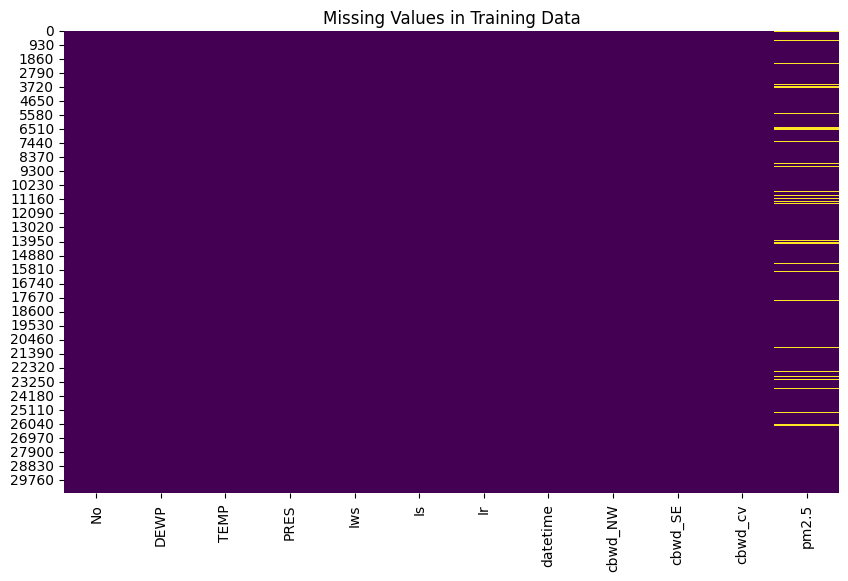

In [4]:
plt.figure(figsize=(10, 6))
sns.heatmap(train.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values in Training Data")
plt.show()

In [5]:
import os
os.makedirs('submissions', exist_ok=True)

**2: Data Preprocessing**

In [6]:
# Preprocessing
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])
train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

# Handle missing values (if any)
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(train.drop(['pm2.5', 'No'], axis=1))
scaled_test_features = scaler.transform(test.drop(['No'], axis=1))

# Reshape for LSTM (samples, timesteps=1, features)
X_train = scaled_features.reshape(scaled_features.shape[0], 1, scaled_features.shape[1])
X_test = scaled_test_features.reshape(scaled_test_features.shape[0], 1, scaled_test_features.shape[1])
y_train = train['pm2.5']

**3: Model Building Function**

In [18]:
# Function to build and compile a model
def build_model(architecture, learning_rate):
    model = Sequential()
    for layer in architecture:
        if layer['type'] == 'LSTM':
            model.add(LSTM(layer['units'], activation='relu', return_sequences=layer.get('return_sequences', False)))
        elif layer['type'] == 'Bidirectional':
            model.add(Bidirectional(LSTM(layer['units'], activation='relu', return_sequences=layer.get('return_sequences', False))))
        elif layer['type'] == 'Dense':
            model.add(Dense(layer['units'], activation='relu'))
        elif layer['type'] == 'Dropout':
            model.add(Dropout(layer['rate']))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

**4: Experiment Configurations**

In [19]:
# Experiment configurations
experiments = [
    {
        'name': 'Experiment 1',
        'architecture': [
            {'type': 'LSTM', 'units': 128, 'return_sequences': True},
            {'type': 'Dropout', 'rate': 0.3},
            {'type': 'LSTM', 'units': 64},
            {'type': 'Dropout', 'rate': 0.2},
            {'type': 'Dense', 'units': 32},
            {'type': 'Dropout', 'rate': 0.2}
        ],
        'learning_rate': 0.001
    },
    {
        'name': 'Experiment 2',
        'architecture': [
            {'type': 'LSTM', 'units': 256, 'return_sequences': True},
            {'type': 'Dropout', 'rate': 0.3},
            {'type': 'LSTM', 'units': 128},
            {'type': 'Dropout', 'rate': 0.2}
        ],
        'learning_rate': 0.0001
    },
    {
        'name': 'Experiment 3',
        'architecture': [
            {'type': 'Bidirectional', 'units': 128, 'return_sequences': True},
            {'type': 'Dropout', 'rate': 0.3},
            {'type': 'Bidirectional', 'units': 64},
            {'type': 'Dropout', 'rate': 0.2}
        ],
        'learning_rate': 0.001
    },
    {
        'name': 'Experiment 4',
        'architecture': [
            {'type': 'LSTM', 'units': 128, 'return_sequences': True},
            {'type': 'Dropout', 'rate': 0.3},
            {'type': 'LSTM', 'units': 64, 'return_sequences': True},
            {'type': 'Dropout', 'rate': 0.2},
            {'type': 'LSTM', 'units': 32},
            {'type': 'Dropout', 'rate': 0.2}
        ],
        'learning_rate': 0.0005
    },
    {
        'name': 'Experiment 5',
        'architecture': [
            {'type': 'Bidirectional', 'units': 256, 'return_sequences': True},
            {'type': 'Dropout', 'rate': 0.3},
            {'type': 'Bidirectional', 'units': 128},
            {'type': 'Dropout', 'rate': 0.2}
        ],
        'learning_rate': 0.0001
    },
    {
        'name': 'Experiment 6',
        'architecture': [
            {'type': 'LSTM', 'units': 64},
            {'type': 'Dropout', 'rate': 0.2},
            {'type': 'Dense', 'units': 32},
            {'type': 'Dropout', 'rate': 0.2}
        ],
        'learning_rate': 0.001
    },
    {
        'name': 'Experiment 7',
        'architecture': [
            {'type': 'LSTM', 'units': 128, 'return_sequences': True},
            {'type': 'Dropout', 'rate': 0.3},
            {'type': 'LSTM', 'units': 64, 'return_sequences': True},
            {'type': 'Dropout', 'rate': 0.2},
            {'type': 'LSTM', 'units': 32},
            {'type': 'Dropout', 'rate': 0.2}
        ],
        'learning_rate': 0.0001
    },
    {
        'name': 'Experiment 8',
        'architecture': [
            {'type': 'Bidirectional', 'units': 128, 'return_sequences': True},
            {'type': 'Dropout', 'rate': 0.3},
            {'type': 'Bidirectional', 'units': 64},
            {'type': 'Dropout', 'rate': 0.2},
            {'type': 'Dense', 'units': 32},
            {'type': 'Dropout', 'rate': 0.2}
        ],
        'learning_rate': 0.0005
    },
    {
        'name': 'Experiment 9',
        'architecture': [
            {'type': 'LSTM', 'units': 256, 'return_sequences': True},
            {'type': 'Dropout', 'rate': 0.3},
            {'type': 'LSTM', 'units': 128, 'return_sequences': True},
            {'type': 'Dropout', 'rate': 0.2},
            {'type': 'LSTM', 'units': 64},
            {'type': 'Dropout', 'rate': 0.2}
        ],
        'learning_rate': 0.0001
    },
    {
        'name': 'Experiment 10',
        'architecture': [
            {'type': 'Bidirectional', 'units': 256, 'return_sequences': True},
            {'type': 'Dropout', 'rate': 0.3},
            {'type': 'Bidirectional', 'units': 128, 'return_sequences': True},
            {'type': 'Dropout', 'rate': 0.2},
            {'type': 'Bidirectional', 'units': 64},
            {'type': 'Dropout', 'rate': 0.2}
        ],
        'learning_rate': 0.0001
    },
    {
        'name': 'Experiment 11',
        'architecture': [
            {'type': 'Bidirectional', 'units': 64, 'return_sequences': True, 'kernel_regularizer': 'l2(0.01)'},
            {'type': 'Dropout', 'rate': 0.4},
            {'type': 'Bidirectional', 'units': 32},
            {'type': 'Dropout', 'rate': 0.3}
        ],
        'learning_rate': 0.0005
    },
    # Experiment 12: GRU + Dense Layers
    {
        'name': 'Experiment 12',
        'architecture': [
            {'type': 'GRU', 'units': 128, 'return_sequences': True},
            {'type': 'Dropout', 'rate': 0.3},
            {'type': 'GRU', 'units': 64},
            {'type': 'Dropout', 'rate': 0.2},
            {'type': 'Dense', 'units': 32}
        ],
        'learning_rate': 0.0001
    },
    # Experiment 13: Hybrid CNN-LSTM
    {
        'name': 'Experiment 13',
        'architecture': [
            {'type': 'LSTM', 'units': 128, 'return_sequences': True},
            {'type': 'Dropout', 'rate': 0.3},
            {'type': 'LSTM', 'units': 64},
            {'type': 'Dropout', 'rate': 0.2}
        ],
        'learning_rate': 0.0005
    },
]

**5: Running Experiments**

In [20]:
# Run experiments
results = []
for i, exp in enumerate(experiments):
    print(f"Running {exp['name']}...")
    model = build_model(exp['architecture'], exp['learning_rate'])
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[early_stopping], verbose=0)
    
    # Evaluate on training data
    y_pred = model.predict(X_train).flatten()
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    
    # Record results
    results.append({
        'Experiment': exp['name'],
        'Learning Rate': exp['learning_rate'],
        'Model Architecture': exp['architecture'],
        'RMSE': rmse
    })
    
    print(f"{exp['name']} - RMSE: {rmse}")

    # Make predictions on test data
    predictions = model.predict(X_test).flatten()

    # Save predictions to CSV
    submission = pd.DataFrame({
        'row ID': test.index.strftime('%Y-%m-%d ') + test.index.hour.astype(str) + ':' + test.index.minute.astype(str).str.zfill(2) + ':' + test.index.second.astype(str).str.zfill(2),
        'pm2.5': predictions
    })
# Save the DataFrame to a CSV file
submission.to_csv(f'submissions/submission_experiment_{i+1}.csv', index=False)

Running Experiment 1...
959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Experiment 1 - RMSE: 70.91267460188372
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Running Experiment 2...
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
Experiment 2 - RMSE: 72.01132212713509
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Running Experiment 3...
959/959 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
Experiment 3 - RMSE: 70.3857784021204
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Running Experiment 4...
959/959 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step
Experiment 4 - RMSE: 70.97507720760022
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Running Experiment 5...
959/959 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step
Experiment 5 - RMSE: 71.4069421075645
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
Running Experiment 6...
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
Experiment 6 - RMSE: 70.83992684075528
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Running Experiment 7...
959/959 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step
Experiment 7 - RMSE: 72.81377533440602
411/411 ━━━━━━━━━━━━━━━

In [21]:
# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Save results to CSV
results_df.to_csv('experiment_results.csv', index=False)

       Experiment  Learning Rate  \
0    Experiment 1         0.0010   
1    Experiment 2         0.0001   
2    Experiment 3         0.0010   
3    Experiment 4         0.0005   
4    Experiment 5         0.0001   
5    Experiment 6         0.0010   
6    Experiment 7         0.0001   
7    Experiment 8         0.0005   
8    Experiment 9         0.0001   
9   Experiment 10         0.0001   
10  Experiment 11         0.0005   
11  Experiment 12         0.0001   
12  Experiment 13         0.0005   

                                   Model Architecture       RMSE  
0   [{'type': 'LSTM', 'units': 128, 'return_sequen...  70.912675  
1   [{'type': 'LSTM', 'units': 256, 'return_sequen...  72.011322  
2   [{'type': 'Bidirectional', 'units': 128, 'retu...  70.385778  
3   [{'type': 'LSTM', 'units': 128, 'return_sequen...  70.975077  
4   [{'type': 'Bidirectional', 'units': 256, 'retu...  71.406942  
5   [{'type': 'LSTM', 'units': 64}, {'type': 'Drop...  70.839927  
6   [{'type': 'LSTM', 'uni

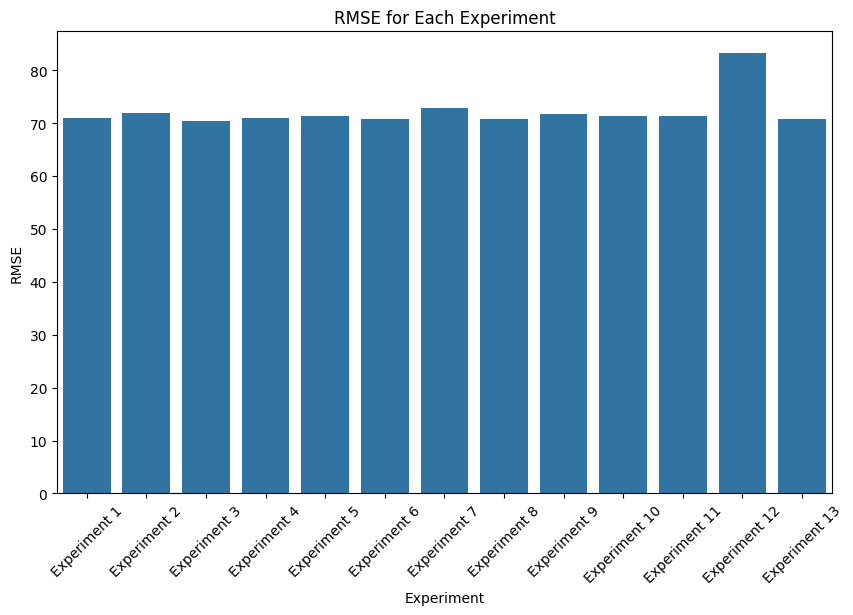

Epoch 1/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step - loss: 10094.0596 - mae: 69.5559
Epoch 2/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 5481.7725 - mae: 51.4384
Epoch 3/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 5703.7881 - mae: 51.9906
Epoch 4/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 5288.4888 - mae: 50.5670
Epoch 5/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 5321.8384 - mae: 50.7690


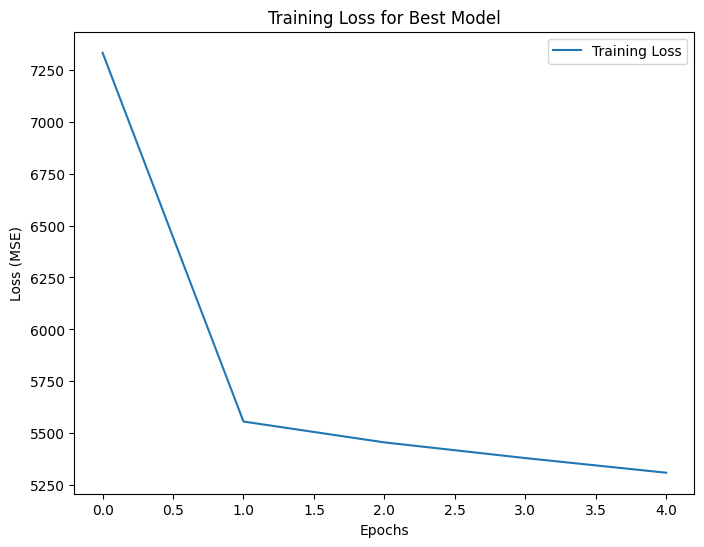

In [22]:
# Plot RMSE for each experiment
plt.figure(figsize=(10, 6))
sns.barplot(x='Experiment', y='RMSE', data=results_df)
plt.title('RMSE for Each Experiment')
plt.xticks(rotation=45)
plt.show()

# Plot training loss for the best model
best_exp = results_df.loc[results_df['RMSE'].idxmin()]
best_model = build_model(best_exp['Model Architecture'], best_exp['Learning Rate'])
history = best_model.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[early_stopping], verbose=1)

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss for Best Model')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

**8: Train and Save the Best Model**

In [23]:
# Train the best model (lowest RMSE)
best_exp = results_df.loc[results_df['RMSE'].idxmin()]
print(f"Best Experiment: {best_exp['Experiment']} with RMSE: {best_exp['RMSE']}")

best_model = build_model(best_exp['Model Architecture'], best_exp['Learning Rate'])
best_model.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[early_stopping], verbose=1)

# Make predictions on test data
predictions = best_model.predict(X_test).flatten()

# Prepare submission file for the best model
submission = pd.DataFrame({
    'row ID': test.index.strftime('%Y-%m-%d ') + test.index.hour.astype(str) + ':' + test.index.minute.astype(str).str.zfill(2) + ':' + test.index.second.astype(str).str.zfill(2),
    'pm2.5': predictions
})
submission.to_csv('best_submission.csv', index=False)

Best Experiment: Experiment 3 with RMSE: 70.3857784021204
Epoch 1/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 148s 26ms/step - loss: 10524.1074 - mae: 71.1455
Epoch 2/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - loss: 5573.1636 - mae: 52.1314
Epoch 3/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 31s 30ms/step - loss: 5463.1753 - mae: 51.1692
Epoch 4/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - loss: 5597.0718 - mae: 51.4580
Epoch 5/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - loss: 5530.8237 - mae: 51.0310
411/411 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step
